# SPARK Dataset


## Imports

In [24]:
from spark_utils import PyTorchSparkDataset, SPARKDataset
from matplotlib import pyplot as plt
from random import randint
import os


In [25]:
import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate

# We are using BETA APIs, so we deactivate the associated warning, thereby acknowledging that
# some APIs may slightly change in the future
torchvision.disable_beta_transforms_warning()


## Defining the Dataset

By default, the output structure of the dataset is not compatible with the models or the transforms (https://pytorch.org/vision/master/transforms.html#v1-or-v2-which-one-should-i-use). To overcome that, we wrap a `PyTorchSparkDataset` in`PyTorchSparkDatasetV2`.

In the code below, we are wrapping images and bounding boxes `torchvision.TVTensor classes` so that we will be able to apply torchvision built-in transformations for the given object detection and segmentation task. Namely, image tensors will be wrapped by `torchvision.tv_tensors.Image` and bounding boxes into `torchvision.tv_tensors.BoundingBoxes`. Our dataset now returns a target which is dict where the values are `TVTensors` (all are `torch.Tensor` subclasses).

We also make the dataset compliant with COCO requirements so that it will work for both training and evaluation codes from the COCO reference script.

In [26]:
# Wrap a PyTorchSparkDataset dataset for usage with torchvision.transforms.v2
class PyTorchSparkDatasetV2(torch.utils.data.Dataset):
    def __init__(
        self,
        class_map,
        split="train",
        root_dir="./data/",
        transforms=None,
        sample_size=1,
    ):
        self.dataset = PyTorchSparkDataset(
            class_map, split=split, root_dir=root_dir, sample_size=sample_size
        )
        self.transforms = transforms
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.split == "test":
            img, img_name = self.dataset[idx]
            img = tv_tensors.Image(img)

            if self.transforms is not None:
                img = self.transforms(img)

            return img, img_name

        else:
            img, label, bbox = self.dataset[idx]

            img = tv_tensors.Image(img)

            bbox = tv_tensors.BoundingBoxes(
                bbox, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=F.get_size(img)
            )
            label = torch.tensor([label])
            area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
            iscrowd = torch.zeros((1,), dtype=torch.int64)
            image_id = idx

            target = {
                "boxes": bbox,
                "labels": label,
                "area": area,
                "iscrowd": iscrowd,
                "image_id": image_id,
            }

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target


## Transforms

Let’s now define our pre-processing transforms. All the transforms know how to handle images, bouding boxes and masks when relevant.

Transforms are typically passed as the transforms parameter of the dataset so that they can leverage multi-processing from the `torch.utils.data.DataLoader`.

If the data is intended for training, a series of augmentation techniques are used. These include `RandomPhotometricDistort` to apply random color distortions (this helps the model generalize better across varying lighting conditions), and `RandomZoomOut` which randomly zooms out of the image (creating new perspectives and scales for the model to learn from).

The `RandomIoUCrop` performs a random crop based on the intersection-over-union (IoU) of the bounding boxes, and `RandomHorizontalFlip` and `RandomVerticalFlip` randomly flips the image horizontally and vertically (increasing the diversity of orientations). The `SanitizeBoundingBoxes` function adjusts and sanitizes the bounding boxes after these transformations are applied.

- http://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#transforms-v2-end-to-end-object-detection-segmentation-example
- https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

In [27]:
# Define the transforms to be applied to the data.
def get_transform(split):
    """Defines tranforms for datasets."""
    transforms = []
    transforms.append(T.ToImage())

    if split == "train":
        transforms.append(T.RandomPhotometricDistort(p=0.5))
        transforms.append(
            T.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0})
        )
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomHorizontalFlip(p=0.5))
        transforms.append(T.RandomVerticalFlip(p=0.5))
        transforms.append(T.SanitizeBoundingBoxes())

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)


## Loading Datasets

In [28]:
def get_dataset(split, class_map, data_path, sample_size=1):
    """Returns dataset."""
    # We use the PyTorchSparkDatasetV2 class defined above.
    dataset = PyTorchSparkDatasetV2(
        class_map=class_map,
        split=split,
        root_dir=data_path,
        transforms=get_transform(split),
        sample_size=sample_size,
    )
    return dataset


In [29]:
# Set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.
# The image sets should be in /data/train, /data/validation and /data/test.
data_path = "./data/"

# Define the class map, this is a dictionary that maps the class names to integer labels.
class_map = {
    "background": 0, # This is the background class
    "proba_2": 1,
    "cheops": 2,
    "debris": 3,
    "double_star": 4,
    "earth_observation_sat_1": 5,
    "lisa_pathfinder": 6,
    "proba_3_csc": 7,
    "proba_3_ocs": 8,
    "smart_1": 9,
    "soho": 10,
    "xmm_newton": 11,
}

# Define the number of classes
num_classes = len(class_map)


In [30]:
# # Define the datasets for training and validation
dataset = get_dataset(
    split="train", class_map=class_map, data_path=data_path
)
dataset_valid = get_dataset(
    split="validation", class_map=class_map, data_path=data_path
)

print(f"Number of training samples: {len(dataset)}")
print(f"Number of validation samples: {len(dataset_valid)}\n")


Number of training samples: 66000
Number of validation samples: 22000



In [31]:
# Check dataset format for debugging purposes
sample = dataset[0]
image, target = sample

print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print()
print(f"Target type: {type(target)}")
print("Target keys: ", list(target.keys()))
print()
print(f"Boxes type: {type(target['boxes'])}")
print(f"Boxes shape: {target['boxes'].shape}")
print()
print(f"Labels type: {type(target['labels'])}")
print(f"Labels shape: {target['labels'].shape}")
print(f"Labels dtype: {target['labels'].dtype}")


Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 1016, 981])
Image dtype: torch.float32

Target type: <class 'dict'>
Target keys:  ['boxes', 'labels', 'area', 'iscrowd', 'image_id']

Boxes type: <class 'torch.Tensor'>
Boxes shape: torch.Size([1, 4])

Labels type: <class 'torch.Tensor'>
Labels shape: torch.Size([1])
Labels dtype: torch.int64


## Visualizing Images

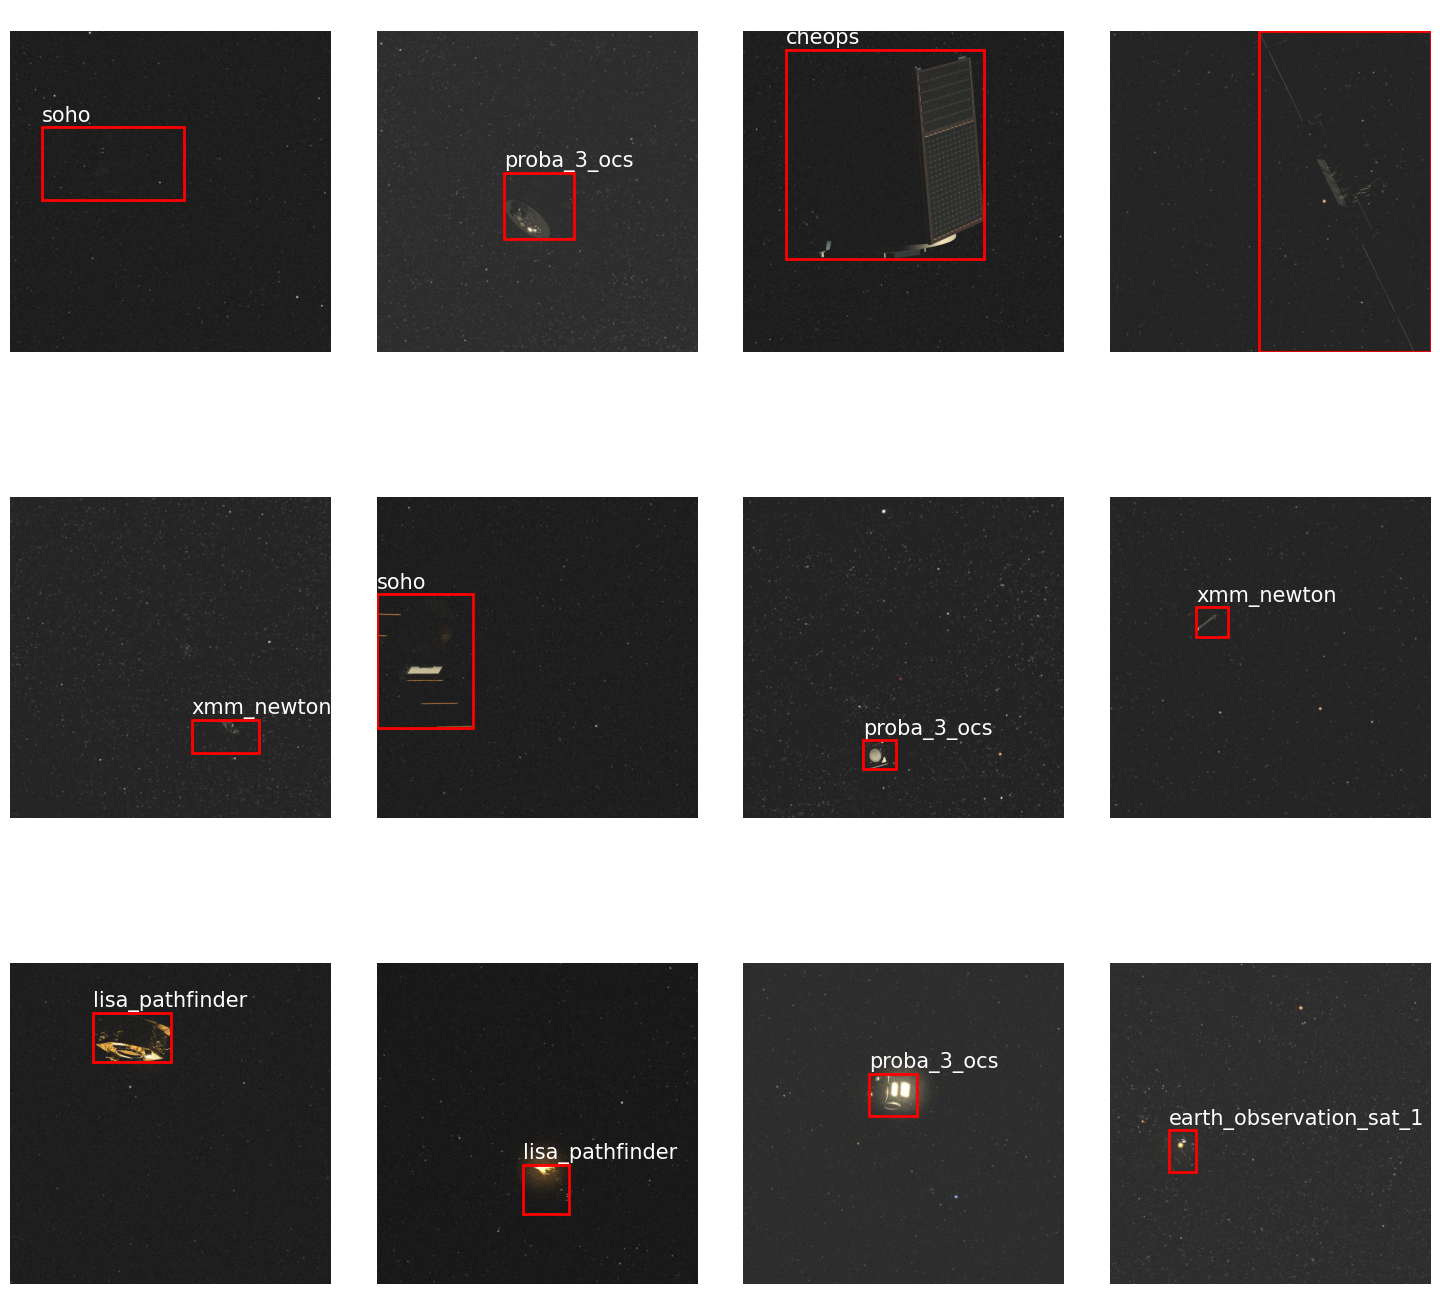

In [32]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path, split="train")

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(ds)), size=(10, 10), ax=axes[i][j])
        axes[i][j].axis("off")

fig.tight_layout()


## Define Dataloaders

In [33]:
# Define the batch size to be used.
batch_size = 4

# Define the dataloaders for training, validation and testing.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)


## Defining Model

We will be using Faster R-CNN V2. Faster R-CNN V2 is a model that predicts both bounding boxes and class scores for potential objects in the image. It works similarly to Faster R-CNN with ResNet-50 FPN backbone.

We will start from a model pre-trained on COCO and finetune it for our particular classes in order to perform transfer learning.

- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html
- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [34]:
# Define the model
def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    # TODO: Experiment with other weights such as 'COCO_V1'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


## Model Training

Below is the main function which performs the training and the validation.

In [35]:
# Run the cell below if you have an error "CUDA is out of memory"
import gc
gc.collect()
torch.cuda.empty_cache()


In [36]:
# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

If you have saved a checkpoint, you can load it and resume training from there. Otherwise, the model will be trained from scratch.

In [37]:
# Flag to indicate whether to train from scratch or not
resume_training = True
start_epoch = 0
num_epochs = 25

if resume_training:
    # Load the state dict previously saved
    model_file = "model_25.pth" # Replace with the name of the model file
    checkpoint = torch.load(model_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    start_epoch = checkpoint['epoch'] + 1


In [15]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# If resuming training, load optimizer and lr_scheduler states
if resume_training:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])


In [ ]:
# Let's train it for num_epochs epochs
for epoch in range(start_epoch, num_epochs):
    # Train for one epoch, printing every 100 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)

    # Save the model, optimizer and lr_scheduler after each epoch
    state = {
        # TODO: save metrics after each epoch
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    }
    torch.save(state, f'model_{epoch}.pth')


## Compute Predictions

In [38]:
dataset_test = get_dataset(
    split="test", class_map=class_map, data_path=data_path
)

print(f"Number of test samples: {len(dataset_test)}\n")


Number of test samples: 22000



In [39]:
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=lambda batch: tuple(zip(*batch)),
)


In [26]:
# Switch the model to evaluation mode
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

Each image processed by the model could potentially have multiple bounding boxes predicted, each with a confidence score. However, in this script, we've implemented a strategy to keep the prediction process simple and focused. Instead of considering multiple bounding boxes per image, we only take the bounding box with the highest confidence score. This means that for each image, we are predicting a single bounding box, that is, the one that the model is most certain about.

The script also handles cases where no bounding boxes are predicted for an image. In such cases, it records an empty bounding box and class label.


In [27]:
def get_inverse_class_map(class_map):
    """Returns a dictionary that maps integer labels to class names."""
    return {v: k for k, v in class_map.items()}

# Create the inverse class map.
inverse_class_map = get_inverse_class_map(class_map)

def process_predictions(predictions):
    """Processes predictions to keep only the bounding box with the highest score."""
    for i, prediction in enumerate(predictions):
        if prediction['scores'].numel() > 0:
            max_score_index = prediction['scores'].argmax()
            predictions[i] = {key: val[max_score_index].unsqueeze(0) for key, val in prediction.items()}
    return predictions

def write_prediction_to_file(f, prediction, img_name):
    """Writes a single prediction to the file."""
    if prediction['scores'].numel() > 0:
        box = list(map(int, prediction["boxes"].cpu().numpy().squeeze()))
        label = int(prediction["labels"].cpu().numpy().squeeze())
        class_name = inverse_class_map[label]  # Convert the integer label to a class name.
        box_str = str(box)  # Convert the bounding box coordinates to a string.
    else:
        # TODO: Replace by background class name and full size of image
        box_str, class_name = '', ''

    f.write(f'{img_name},{class_name},"{box_str}"\n')


The predictions are then written to a CSV file, with each line in the file corresponding to one image from the test dataset. Each line contains the image name, the predicted class label, and the coordinates of the predicted bounding box.


In [ ]:
# Define the CSV file path
csv_file_path = os.path.join(data_path, 'predictions.csv')

# Open the CSV file and write the header
with open(csv_file_path, "w") as f:
    f.write("filename,class,bbox\n")

# Loop over the test dataset
for i, (images, img_names) in enumerate(data_loader_test):

    # Move the images to the device
    images = [image.to(device) for image in images]

    # Compute the model predictions
    with torch.no_grad():
        predictions = model(images)

    # Process predictions to keep only the bounding box with the highest score
    predictions = process_predictions(predictions)

    # Open the CSV file in append mode and write the predictions
    with open(csv_file_path, "a") as f:
        for prediction, img_name in zip(predictions, img_names):
            write_prediction_to_file(f, prediction, img_name)


## Visualizing Predictions

What do the predictions look like? Let’s take a look at some images in the dataset and verify

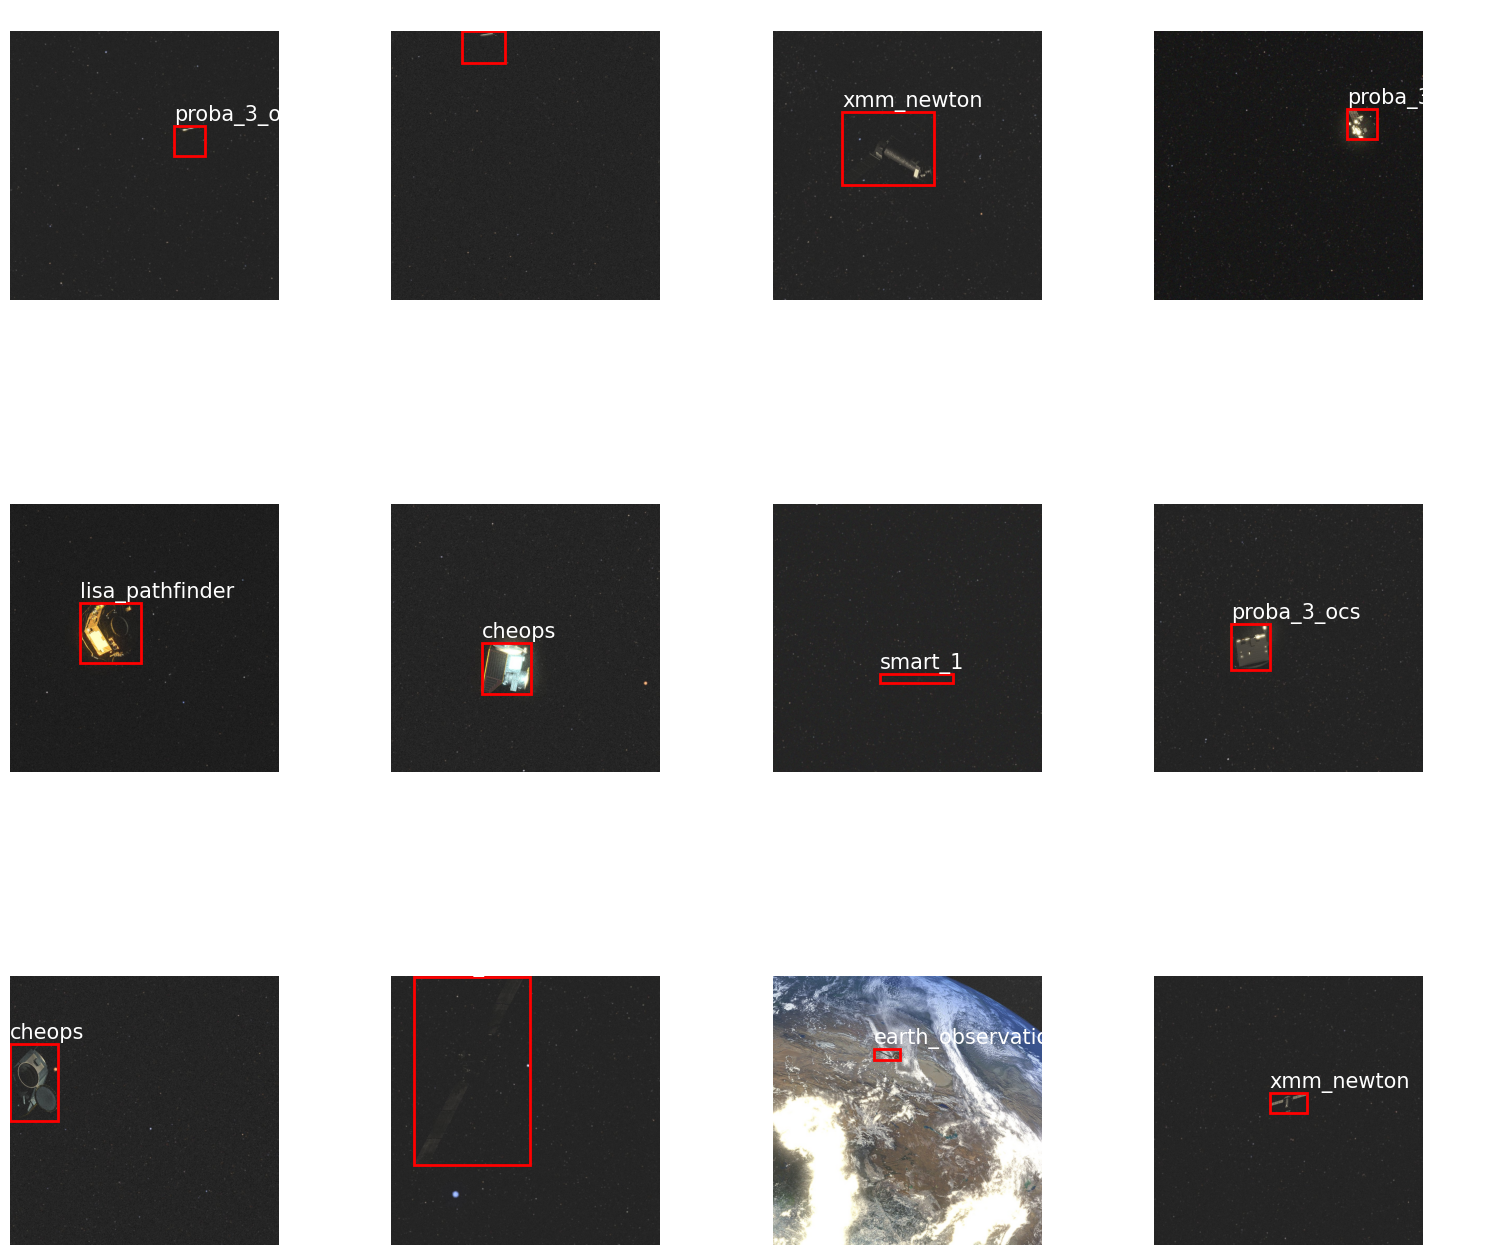

In [41]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path, split="predictions")

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(ds)), size=(10, 10), ax=axes[i][j])
        axes[i][j].axis("off")

fig.tight_layout()


# Model Evaluation

We can now evaluate the models after each epoch and see if the model is improving. We will use the COCO evaluation metrics to evaluate the model.

In [21]:
# Constants for the metrics
AP_METRICS = ["all50-95", "all50", "all75", "small", "medium", "large"]
AR_METRICS = ["all50-95", "small", "medium", "large"]

# Set the epoch range
start_epoch = 0
end_epoch = 25

In [ ]:
# Function to load the model
def load_model_for_epoch(epoch, model):
    model_path = f'model_{epoch}.pth'
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint.get("model_state_dict", checkpoint))
    print(f"model_{epoch}.pth loaded!")

# Function to extract and store metrics
def store_metrics(metrics, ap_values, ar_values):
    stats = metrics.coco_eval["bbox"].stats
    for i, metric in enumerate(AP_METRICS):
        ap_values[metric].append(stats[i])
    for i, metric in enumerate(AR_METRICS, start=8):
        ar_values[metric].append(stats[i])

# Initialize storage for Average Precision (AP) and Average Recall (AR) values
ap_values = {metric: [] for metric in AP_METRICS}
ar_values = {metric: [] for metric in AR_METRICS}

# Main loop
for epoch in range(start_epoch, end_epoch + 1):
    # Load the model
    load_model_for_epoch(epoch, model)
    # Switch the model to evaluation mode
    model.eval()
    # Evaluate on the validation dataset
    metrics = evaluate(model, data_loader_valid, device=device)
    print(f"\nMetrics for Epoch {epoch}:")

    # Store the metrics
    store_metrics(metrics, ap_values, ar_values)


In [ ]:
import pickle

# Save results to external file
with open('ap_values.pkl', 'wb') as f:
    pickle.dump(ap_values, f)

with open('ar_values.pkl', 'wb') as f:
    pickle.dump(ar_values, f)


In [19]:
import pickle

# Load the AP values from file
with open('ap_values.pkl', 'rb') as f:
    ap_values = pickle.load(f)

# Load the AR values from file
with open('ar_values.pkl', 'rb') as f:
    ar_values = pickle.load(f)

# Print the collected AP and AR values
print("AP values:", ap_values)
print("AR values:", ar_values)

AP values: {'all50-95': [0.6924760305704072, 0.7016052270401817, 0.6983876224321148, 0.7904908948164483, 0.8001813964125655, 0.8090058073671765, 0.8182574617362562, 0.8190833051263792, 0.820982115840439, 0.8218650147376368, 0.8232026880157206, 0.8236510822841951, 0.8241859372627509, 0.8231057967532069, 0.8232941026561047, 0.8223449083285908, 0.8193049174679835, 0.8216331916752763, 0.8238624079332442, 0.8228035471634594, 0.8229450323288137, 0.8220367425266506, 0.8239135839760215, 0.822684268604147, 0.8229610026818048, 0.8238478661970817], 'all50': [0.9421583580352276, 0.9552095718303955, 0.9451619663312847, 0.976201159530632, 0.9803846313563259, 0.979935464655828, 0.9824235988935834, 0.9830290933895319, 0.9831328358758021, 0.9831781011389139, 0.9829260838316507, 0.9832027002700295, 0.983346769811226, 0.9830165115632998, 0.9833539866196775, 0.9833017057125276, 0.9820588469882698, 0.9831435489546025, 0.9833823671635998, 0.982817839917346, 0.9830892017655025, 0.9828586521728786, 0.98288632

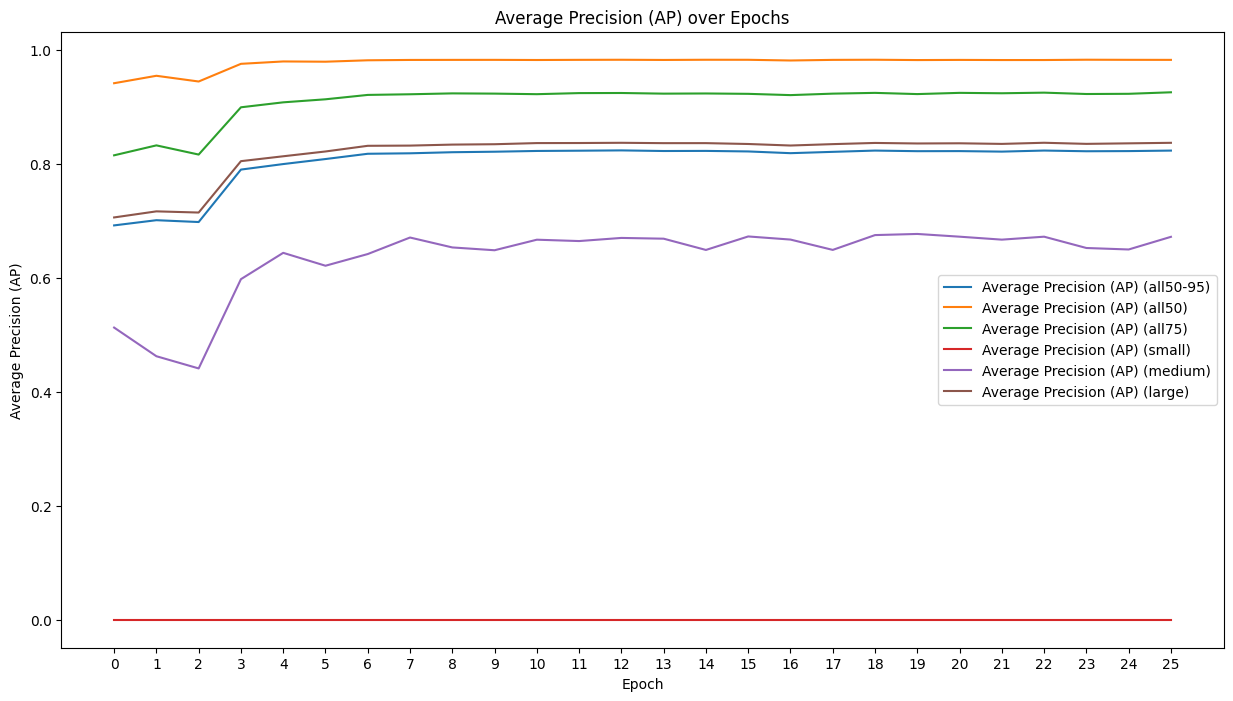

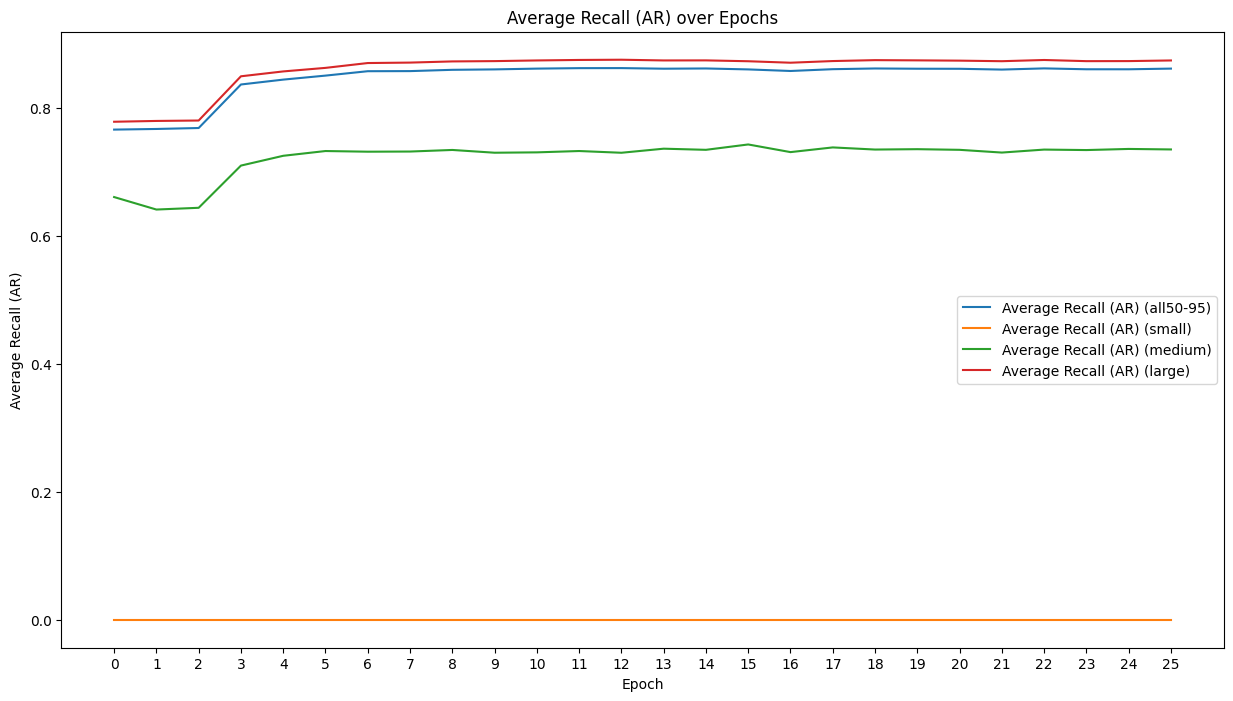

In [22]:
def plot_metrics(metrics_values, metric_name, start_epoch, end_epoch):
    plt.figure(figsize=(15, 8))
    epochs = range(start_epoch, end_epoch + 1)
    for area, values in metrics_values.items():
        plt.plot(epochs, values, label=f"{metric_name} ({area})")

    plt.xticks(epochs)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs")
    plt.legend()
    plt.show()

# Plotting Average Precision values
plot_metrics(ap_values, "Average Precision (AP)", start_epoch, end_epoch)

# Plotting Average Recall values
plot_metrics(ar_values, "Average Recall (AR)", start_epoch, end_epoch)
